In [1]:
import torch
import subprocess
import sys

def check_pytorch_installation():
    print("=== PyTorch Installation Check ===")
    
    # PyTorch version
    print(f"PyTorch version: {torch.__version__}")
    print(f"Python version: {sys.version}")
    
    # CUDA check
    print(f"\nCUDA available: {torch.cuda.is_available()}")
    
    if torch.cuda.is_available():
        print(f"CUDA version (PyTorch): {torch.version.cuda}")
        print(f"cuDNN version: {torch.backends.cudnn.version()}")
        print(f"Number of GPUs: {torch.cuda.device_count()}")
        
        # GPU details
        for i in range(torch.cuda.device_count()):
            print(f"\nGPU {i}:")
            print(f"  Name: {torch.cuda.get_device_name(i)}")
            print(f"  Memory: {torch.cuda.get_device_properties(i).total_memory / 1024**3:.1f} GB")
        
        # Test computation
        print("\n=== Testing GPU Computation ===")
        try:
            device = torch.device("cuda")
            a = torch.randn(1000, 1000, device=device)
            b = torch.randn(1000, 1000, device=device)
            c = torch.matmul(a, b)
            print("✅ GPU computation test passed!")
        except Exception as e:
            print(f"❌ GPU computation test failed: {e}")
    else:
        print("❌ CUDA is not available")
        
        # Check if NVIDIA driver is installed
        try:
            result = subprocess.run(['nvidia-smi'], capture_output=True, text=True)
            if result.returncode == 0:
                print("✅ NVIDIA driver is installed")
                print("ℹ️  You may need to install CUDA-enabled PyTorch")
            else:
                print("❌ NVIDIA driver may not be installed")
        except FileNotFoundError:
            print("❌ nvidia-smi not found - NVIDIA driver may not be installed")

if __name__ == "__main__":
    check_pytorch_installation()

=== PyTorch Installation Check ===
PyTorch version: 2.7.0+cu118
Python version: 3.12.9 | packaged by Anaconda, Inc. | (main, Feb  6 2025, 18:49:16) [MSC v.1929 64 bit (AMD64)]

CUDA available: True
CUDA version (PyTorch): 11.8
cuDNN version: 90100
Number of GPUs: 1

GPU 0:
  Name: NVIDIA GeForce RTX 4090
  Memory: 24.0 GB

=== Testing GPU Computation ===
✅ GPU computation test passed!


In [ ]:
import sys
import os

# Ensure PyTorch backend for Keras
sys.modules['tensorflow'] = None
sys.modules['jax'] = None

gpu_use = 0
print(f"GPU use: {gpu_use}")
os.environ["KERAS_BACKEND"] = "torch"
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_use}"

# Enable mixed precision training
os.environ["KERAS_FLOATX"] = "float16"  # Set default float type to float16

# Import necessary libraries
import numpy as np
import nibabel as nib
import glob
from pathlib import Path
import random
from sklearn.utils import class_weight
import matplotlib.pyplot as plt

# Keras and model imports
from classification_models_3D.kkeras import Classifiers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from keras import backend as K
from keras.layers import Dropout, Dense, Activation, GlobalAveragePooling3D
from keras.models import Model
from keras.src.utils import summary_utils
from keras.utils import to_categorical
from keras.mixed_precision import Policy, set_global_policy
import volumentations

# Set mixed precision policy
policy = Policy('mixed_float16')
set_global_policy(policy)
print(f"Mixed precision policy: {policy}")
print(f"Compute dtype: {policy.compute_dtype}")
print(f"Variable dtype: {policy.variable_dtype}")

GPU use: 0
Mixed precision policy: <DTypePolicy "mixed_float16">
Compute dtype: float16
Variable dtype: float32


In [3]:
CONFIG = {
    'data_path': r'D:\Kananat_Arm\Data\TMJOA\training_dataset',  # Update this path
    'shape_size': (224, 224, 224, 1),      # Resize to this shape (adjust as needed)
    'backbone': 'resnet18',                # Model architecture
    'num_classes': 2,                      # Number of classes
    'batch_size_train': 8,                 # Batch size for training
    'batch_size_valid': 8,                 # Batch size for validation
    'learning_rate': 0.001,               # Initial learning rate
    'patience': 25,                        # Early stopping patience
    'epochs': 100,                         # Maximum epochs
    'dropout_val': 0.2,                    # Dropout rate
    'seed': 42,                            # Random seed
    'class_folders': ['0', '1'],  # Update with your class folder names
}

random.seed(CONFIG['seed'])
np.random.seed(CONFIG['seed'])

In [ ]:
def load_nii_file(file_path):
    """Load a .nii.gz file and return the image data"""
    nii_img = nib.load(file_path)
    return nii_img.get_fdata()

def normalize_volume(volume):
    """Normalize volume to [0, 1] range"""
    volume = volume.astype(np.float32)  # Keep as float32 for preprocessing
    # Remove outliers using percentile clipping
    p1, p99 = np.percentile(volume[volume > 0], [1, 99])
    volume = np.clip(volume, p1, p99)
    
    # Normalize to [0, 1]
    volume = (volume - volume.min()) / (volume.max() - volume.min() + 1e-8)
    return volume

def resize_volume(volume, target_shape):
    """Resize volume to target shape using simple interpolation"""
    from scipy.ndimage import zoom
    
    # Calculate zoom factors for each dimension
    zoom_factors = [target_shape[i] / volume.shape[i] for i in range(3)]
    
    # Resize the volume
    resized_volume = zoom(volume, zoom_factors, order=1)
    return resized_volume

def get_augmentation(patch_size):
    return volumentations.Compose([
        volumentations.Rotate((-15, 15), (0, 0), (0, 0), p=0.5),
        volumentations.RandomCropFromBorders(crop_value=0.1, p=0.5),
        volumentations.ElasticTransform((0, 0.25), interpolation=2, p=0.1),
        volumentations.Resize(patch_size, interpolation=1, resize_type=0, always_apply=True, p=1.0),
        volumentations.Flip(0, p=0.5),
        volumentations.Flip(1, p=0.5),
        volumentations.Flip(2, p=0.5),
        volumentations.RandomRotate90((1, 2), p=0.5),
        volumentations.GaussianNoise(var_limit=(0, 5), p=0.2),
        volumentations.RandomGamma(gamma_limit=(80, 120), p=0.2),
    ], p=1.0)

def augment_volume(volume):

    augment = get_augmentation(volume.shape)
    augmented_volume = augment(image=volume)["image"]
    
    return augmented_volume

def load_dataset_paths(data_path, split='train'):
    """Load file paths for a specific split"""
    split_path = Path(data_path) / split
    file_paths = []
    labels = []
    
    for class_idx, class_name in enumerate(CONFIG['class_folders']):
        class_path = split_path / class_name
        class_files = glob.glob(str(class_path / "*.nii.gz"))
        
        file_paths.extend(class_files)
        labels.extend([class_idx] * len(class_files))
    
    return file_paths, labels

# Load dataset paths
train_paths, train_labels = load_dataset_paths(CONFIG['data_path'], 'train')
val_paths, val_labels = load_dataset_paths(CONFIG['data_path'], 'val')
test_paths, test_labels = load_dataset_paths(CONFIG['data_path'], 'test')

print(f"Training samples: {len(train_paths)}")
print(f"Validation samples: {len(val_paths)}")
print(f"Test samples: {len(test_paths)}")
print(f"Class distribution in training: {np.bincount(train_labels)}")

Training samples: 254
Validation samples: 73
Test samples: 37
Class distribution in training: [114 140]


In [5]:
class NiftiDataGenerator:
    def __init__(self, file_paths, labels, batch_size, target_shape, augment=False, preprocess_input=None):
        self.file_paths = file_paths
        self.labels = labels
        self.batch_size = batch_size
        self.target_shape = target_shape[:3]  # Remove channel dimension
        self.augment = augment
        self.preprocess_input = preprocess_input
        self.indexes = np.arange(len(self.file_paths))
        self.shuffle()
    
    def shuffle(self):
        """Shuffle the dataset"""
        np.random.shuffle(self.indexes)
    
    def __len__(self):
        """Number of batches per epoch"""
        return len(self.file_paths) // self.batch_size
    
    def __getitem__(self, index):
        """Generate one batch of data"""
        # Get batch indexes
        start_idx = index * self.batch_size
        end_idx = (index + 1) * self.batch_size
        batch_indexes = self.indexes[start_idx:end_idx]
        
        # Generate batch
        return self._generate_batch(batch_indexes)
    
    def _generate_batch(self, batch_indexes):
        """Generate batch of data"""
        # Initialize batch arrays - use float32 for data loading
        batch_images = np.zeros((self.batch_size, *self.target_shape, 1), dtype=np.float32)
        batch_labels = np.zeros((self.batch_size, CONFIG['num_classes']), dtype=np.float32)
        
        # Load and process each file in the batch
        for i, idx in enumerate(batch_indexes):
            # Load volume
            volume = load_nii_file(self.file_paths[idx])
            
            # Normalize
            volume = normalize_volume(volume)
            
            # Resize
            volume = resize_volume(volume, self.target_shape)
            
            # Augment if training
            if self.augment:
                volume = augment_volume(volume)
            
            # Add channel dimension
            volume = np.expand_dims(volume, axis=-1)
            
            # Store in batch
            batch_images[i] = volume
            batch_labels[i] = to_categorical(self.labels[idx], CONFIG['num_classes'])
        
        # Apply preprocessing if provided
        if self.preprocess_input is not None:
            batch_images = self.preprocess_input(batch_images)
        
        # Convert to float16 for training (Keras will handle this automatically with mixed precision)
        return batch_images, batch_labels

def batch_generator(file_paths, labels, batch_size, target_shape, augment=False, preprocess_input=None):
    """Create a generator that yields batches indefinitely"""
    data_gen = NiftiDataGenerator(file_paths, labels, batch_size, target_shape, augment, preprocess_input)
    
    while True:
        # Shuffle at the beginning of each epoch
        data_gen.shuffle()
        
        # Yield all batches
        for i in range(len(data_gen)):
            yield data_gen[i]

In [6]:
def get_model_memory_usage(batch_size, model):
    """Calculate approximate memory usage of the model"""
    shapes_mem_count = 0
    internal_model_mem_count = 0
    for l in model.layers:
        layer_type = l.__class__.__name__
        if layer_type == 'Model' or layer_type == 'Functional':
            internal_model_mem_count += get_model_memory_usage(batch_size, l)
        single_layer_mem = 1
        out_shape = l.output.shape
        if type(out_shape) is list:
            out_shape = out_shape[0]
        for s in out_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = summary_utils.count_params(model.trainable_weights)
    non_trainable_count = summary_utils.count_params(model.non_trainable_weights)

    number_size = 4.0
    if K.floatx() == 'float16':
        number_size = 2.0
    if K.floatx() == 'float64':
        number_size = 8.0

    total_memory = number_size * (batch_size * shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3) + internal_model_mem_count
    return gbytes

# Create model
def create_model():
    """Create and compile the 3D classification model"""
    # Get the base model
    modelPoint, preprocess_input = Classifiers.get(CONFIG['backbone'])
    
    # Create base model without top layers and without pretrained weights
    base_model = modelPoint(
        input_shape=CONFIG['shape_size'],
        include_top=False,
        weights=None,  # Train from scratch
    )
    
    # Add custom top layers
    x = base_model.output
    x = GlobalAveragePooling3D()(x)
    x = Dropout(CONFIG['dropout_val'])(x)
    
    # For mixed precision, ensure the final dense layer outputs float32
    x = Dense(CONFIG['num_classes'], name='prediction', dtype='float32')(x)
    x = Activation('softmax', dtype='float32')(x)  # Softmax in float32 for numerical stability
    
    # Create the final model
    model = Model(inputs=base_model.inputs, outputs=x)
    
    return model, preprocess_input

# Create and compile model
model, preprocess_input = create_model()

print("Model Summary:")
print(model.summary())
print(f"Model memory usage: {get_model_memory_usage(CONFIG['batch_size_train'], model)} GB")

# Compile model
optim = Adam(learning_rate=CONFIG['learning_rate'])

# For mixed precision, you might want to use loss scaling to prevent gradient underflow
model.compile(
    optimizer=optim,
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    # loss_scale='dynamic'  # Uncomment if you experience gradient underflow
)

Model Summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, 224, 224,  │          0 │ -                 │
│                     │ 224, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast (Cast)         │ (None, 224, 224,  │          0 │ data[0][0]        │
│                     │ 224, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, 224, 224,  │          3 │ cast[0][0]        │
│ (BatchNormalizatio… │ 224, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding3d      │ (None, 230, 230,  │          0 │ bn_data[0][0]     │
│ (ZeroPadding3D)     │ 230, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv3D)      │ (None, 112, 112,  │     21,952 │ zero_padding3d[0… │
│                     │ 112, 64)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, 112, 112,  │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ 112, 64)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, 112, 112,  │          0 │ bn0[0][0]         │
│                     │ 112, 64)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding3d_1    │ (None, 114, 114,  │          0 │ relu0[0][0]       │
│ (ZeroPadding3D)     │ 114, 64)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, 56, 56,    │          0 │ zero_padding3d_1… │
│ (MaxPooling3D)      │ 56, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, 56, 56,    │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ 56, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, 56, 56,    │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ 56, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding3d_2    │ (None, 58, 58,    │          0 │ stage1_unit1_rel… │
│ (ZeroPadding3D)     │ 58, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, 56, 56,    │    110,592 │ zero_padding3d_2… │
│ (Conv3D)            │ 56, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, 56, 56,    │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ 56, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, 56, 56,    │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ 56, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding3d_3    │ (None, 58, 58,    │          0 │ stage1_unit1_rel… │
│ (ZeroPadding3D)     │ 58, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, 56, 56,    │    110,592 │ zero_padding3d_3

 Total params: 33,171,397 (126.54 MB)

 Trainable params: 33,163,459 (126.51 MB)

 Non-trainable params: 7,938 (31.01 KB)

None
Model memory usage: 22.13 GB


In [7]:
cache_model_path = f'{CONFIG["backbone"]}_temp.keras'
best_model_path = f'{CONFIG["backbone"]}_best.keras'
history_path = f'history_{CONFIG["backbone"]}_lr_{CONFIG["learning_rate"]}.csv'

callbacks = [
    ModelCheckpoint(
        cache_model_path, 
        monitor='val_loss', 
        verbose=1,
        save_best_only=False
    ),
    ModelCheckpoint(
        best_model_path, 
        monitor='val_loss', 
        verbose=1,
        save_best_only=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.8, 
        patience=5, 
        min_lr=1e-8, 
        min_delta=1e-6, 
        verbose=1, 
        mode='min'
    ),
    CSVLogger(history_path, append=True),
    EarlyStopping(
        monitor='val_loss', 
        patience=CONFIG['patience'], 
        verbose=1, 
        mode='min',
        restore_best_weights=True
    ),
]

In [8]:
train_gen = batch_generator(
    train_paths, 
    train_labels,
    CONFIG['batch_size_train'],
    CONFIG['shape_size'],
    augment=True,
    preprocess_input=preprocess_input
)

val_gen = batch_generator(
    val_paths,
    val_labels,
    CONFIG['batch_size_valid'],
    CONFIG['shape_size'],
    augment=False,
    preprocess_input=preprocess_input
)

# Calculate steps per epoch
steps_per_epoch = len(train_paths) // CONFIG['batch_size_train']
validation_steps = len(val_paths) // CONFIG['batch_size_valid']

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")


Steps per epoch: 31
Validation steps: 9


In [ ]:
# Train the model
print("Starting training...")
history = model.fit(
    train_gen,
    epochs=CONFIG['epochs'],
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=validation_steps,
    verbose=1,
    callbacks=callbacks
)

print("Training completed!")

Steps per epoch: 31
Validation steps: 9
Starting training...


c:\Users\IGB\anaconda3\envs\tmjoa_3d\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['data']
Received: inputs=Tensor(shape=torch.Size([8, 224, 224, 224, 1]))
  warnings.warn(msg)


Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.6216 - loss: 0.7107 
Epoch 1: saving model to resnet18_temp.keras

Epoch 1: val_loss did not improve from inf
31/31 ━━━━━━━━━━━━━━━━━━━━ 753s 25s/step - accuracy: 0.6222 - loss: 0.7092 - val_accuracy: 0.4444 - val_loss: nan - learning_rate: 0.0010
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.6770 - loss: 0.5797 
Epoch 2: saving model to resnet18_temp.keras

Epoch 2: val_loss improved from inf to 8.73063, saving model to resnet18_best.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 561s 18s/step - accuracy: 0.6771 - loss: 0.5804 - val_accuracy: 0.4583 - val_loss: 8.7306 - learning_rate: 0.0010
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.7340 - loss: 0.6248 
Epoch 3: saving model to resnet18_temp.keras

Epoch 3: val_loss improved from 8.73063 to 2.95392, saving model to resnet18_best.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 560s 18s/step - accuracy: 0.7333 - loss: 0.6251 - val_accuracy: 0.5694 - val_loss: 

In [9]:
def plot_training_history(history):
    """Plot training and validation loss and accuracy"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot loss
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    # Plot accuracy
    ax2.plot(history.history['accuracy'], label='Training Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

In [ ]:
# Plot training history
plot_training_history(history)

# Load best model for evaluation
print("Loading best model for evaluation...")
model.load_weights(best_model_path)

# Evaluate on test set
test_gen = batch_generator(
    test_paths,
    test_labels,
    CONFIG['batch_size_valid'],
    CONFIG['shape_size'],
    augment=False,
    preprocess_input=preprocess_input
)

test_steps = len(test_paths) // CONFIG['batch_size_valid']
test_loss, test_accuracy = model.evaluate(test_gen, steps=test_steps, verbose=1)

print(f"\nTest Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Get best validation loss from history
best_val_loss = min(history.history['val_loss'])
best_val_accuracy = max(history.history['val_accuracy'])

print(f"\nBest Validation Results:")
print(f"Best Validation Loss: {best_val_loss:.4f}")
print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")

NameError: name 'history' is not defined

In [10]:
# Load the best model and continue training

# Specify the path to your saved model
best_model_path = r'D:\Kananat_Arm\Code\Project_TMJOA\3D_Pipeline\resnet18_continued.keras'

# Load the model
from keras.models import load_model
loaded_model = load_model(best_model_path)

CONFIG = {
    'data_path': r'D:\Kananat_Arm\Data\TMJOA\training_dataset',  # Update this path
    'shape_size': (224, 224, 224, 1),      # Resize to this shape (adjust as needed)
    'backbone': 'resnet18',                # Model architecture
    'num_classes': 2,                      # Number of classes
    'batch_size_train': 8,                 # Batch size for training
    'batch_size_valid': 8,                 # Batch size for validation
    'learning_rate': 0.0005,               # Initial learning rate
    'patience': 25,                        # Early stopping patience
    'epochs': 100,                         # Maximum epochs
    'dropout_val': 0.2,                    # Dropout rate
    'seed': 42,                            # Random seed
    'class_folders': ['0', '1'],  # Update with your class folder names
}

# You can update the learning rate if needed
loaded_model.optimizer.learning_rate = CONFIG['learning_rate']  # Reduce learning rate
print(f"Continuing training with learning rate: {loaded_model.optimizer.learning_rate.numpy()}")

# Update callbacks for continued training
continued_callbacks = [
    ModelCheckpoint(
        f'{CONFIG["backbone"]}_continued2.keras', 
        monitor='val_loss', 
        verbose=1,
        save_best_only=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.8, 
        patience=5, 
        min_lr=1e-8, 
        min_delta=1e-6, 
        verbose=1, 
        mode='min'
    ),
    CSVLogger(f'history_{CONFIG["backbone"]}_continued2.csv', append=True),
    EarlyStopping(
        monitor='val_loss', 
        patience=CONFIG['patience'], 
        verbose=1, 
        mode='min',
        restore_best_weights=True
    ),
]

# Continue training
continue_epochs = 100  # Number of additional epochs
continued_history = loaded_model.fit(
    train_gen,
    epochs=continue_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=validation_steps,
    verbose=1,
    callbacks=continued_callbacks,
    initial_epoch = 28# Start from the last epoch
)

Continuing training with learning rate: 0.0005000000237487257
Epoch 29/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 42s/step - accuracy: 0.8151 - loss: 0.3890 
Epoch 29: val_loss improved from inf to 1.36927, saving model to resnet18_continued2.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 1416s 47s/step - accuracy: 0.8158 - loss: 0.3887 - val_accuracy: 0.5556 - val_loss: 1.3693 - learning_rate: 5.0000e-04
Epoch 30/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 43s/step - accuracy: 0.8262 - loss: 0.3744 
Epoch 30: val_loss improved from 1.36927 to 0.37618, saving model to resnet18_continued2.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 1422s 47s/step - accuracy: 0.8261 - loss: 0.3741 - val_accuracy: 0.8333 - val_loss: 0.3762 - learning_rate: 5.0000e-04
Epoch 31/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 43s/step - accuracy: 0.9173 - loss: 0.2726 
Epoch 31: val_loss did not improve from 0.37618
31/31 ━━━━━━━━━━━━━━━━━━━━ 1945s 64s/step - accuracy: 0.9161 - loss: 0.2750 - val_accuracy: 0.6250 - val_loss: 0.6798 - learning_rate: 5.0000e-04
Epoch

TypeError: 'History' object is not subscriptable

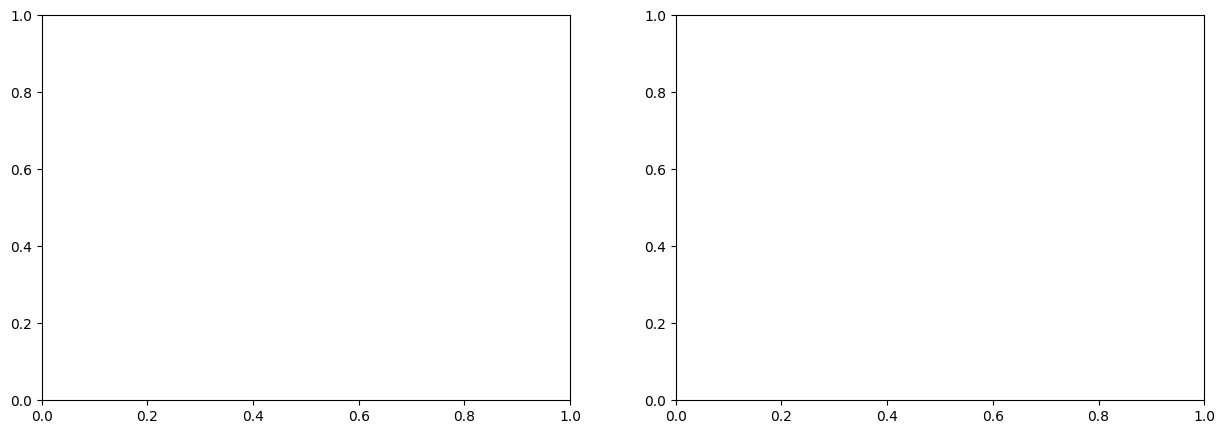

In [12]:
# Combine the histories for plotting
combined_history = {key: continued_history.history[key] 
                     for key in continued_history.history.keys()}

# Plot the combined training history
plot_combined_history = type('obj', (object,), {'history': continued_history})
plot_training_history(plot_combined_history)

print("Continued training completed!")

In [10]:
def predict_single_volume(model, file_path, preprocess_input):
    """Predict class for a single volume"""
    # Load and preprocess volume
    volume = load_nii_file(file_path)
    volume = normalize_volume(volume)
    volume = resize_volume(volume, CONFIG['shape_size'][:3])
    volume = np.expand_dims(volume, axis=-1)
    volume = np.expand_dims(volume, axis=0)  # Add batch dimension
    
    # Apply preprocessing
    if preprocess_input is not None:
        volume = preprocess_input(volume)
    
    # Make prediction (keep as float32 for preprocessing, model handles conversion)
    prediction = model.predict(volume)
    predicted_class = np.argmax(prediction[0])
    confidence = prediction[0][predicted_class]
    
    return predicted_class, confidence, prediction[0]

# Example inference on a test file
if test_paths:
    sample_file = test_paths[0]
    true_label = test_labels[0]
    
    predicted_class, confidence, probabilities = predict_single_volume(
        model, sample_file, preprocess_input
    )
    
    print(f"\nInference Example:")
    print(f"File: {sample_file}")
    print(f"True Label: {true_label}")
    print(f"Predicted Class: {predicted_class}")
    print(f"Confidence: {confidence:.4f}")
    print(f"Class Probabilities: {probabilities}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step

Inference Example:
File: D:\Kananat_Arm\Data\TMJOA\training_dataset\test\0\50-30909 R_adjustedBG.nii.gz
True Label: 0
Predicted Class: 0
Confidence: 0.6334
Class Probabilities: [0.633414   0.36658597]


c:\Users\IGB\anaconda3\envs\tmjoa_3d\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['data']
Received: inputs=Tensor(shape=torch.Size([1, 224, 224, 224, 1]))
  warnings.warn(msg)


In [13]:
# Save the final model
final_model_path = r"D:\Kananat_Arm\Code\Project_TMJOA\3D_Pipeline\resnet18_continued2_final.keras"
loaded_model.save(final_model_path)
print(f"Final model saved to: {final_model_path}")

# Save configuration
import json
config_path = f'{CONFIG["backbone"]}_config.json'
with open(config_path, 'w') as f:
    json.dump(CONFIG, f, indent=4)
print(f"Configuration saved to: {config_path}")

print("Training pipeline completed successfully!")

Final model saved to: D:\Kananat_Arm\Code\Project_TMJOA\3D_Pipeline\resnet18_continued2_final.keras
Configuration saved to: resnet18_config.json
Training pipeline completed successfully!
